In [16]:
#import all the necessary libraries
#import system libs 
import os
import time
import shutil
import itertools

#import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

#import Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [17]:
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


def split_data(tr_dir, ts_dir):
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    
    return train_df, valid_df, test_df

In [20]:
def create_model_data (train_df, valid_df, test_df, batch_size):
    
    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes 
         data from image data generator. 
         Image data generator converts images into tensors. '''
    

    #define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    
    #Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    
    #This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img
    
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    #Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size) 
    
    
    return train_gen, valid_gen, test_gen

In [19]:
def show_images(gen):
    
    g_dict = gen.class_indices      
    classes = list(g_dict.keys())     
    images, labels = next(gen)       
    length = len(labels)        
    sample = min(length, 25)   
    
    plt.figure(figsize= (20, 20))
    
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        
        class_name = classes[index]   
        
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience 
        self.stop_patience = stop_patience 
        self.threshold = threshold 
        self.factor = factor 
        self.batches = batches 
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch 
        self.count = 0 
        self.stop_count = 0
        self.best_epoch = 1  
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) 
        self.highest_tracc = 0.0 
        self.lowest_vloss = np.inf 
        self.best_weights = self.model.get_weights() 
        self.initial_weights = self.model.get_weights()   

    
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans == 'Y' or ans == 'y':
            self.ask_permission = 1
        elif ans == 'N' or ans == 'n':
            self.ask_permission = 0
        
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        
        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        current_lr = lr
        acc = logs.get('accuracy')  
        v_acc = logs.get('val_accuracy') 
        loss = logs.get('loss')  
        v_loss = logs.get('val_loss')  

        if acc < self.threshold: 
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc 
                
            if acc > self.highest_tracc: 
                self.highest_tracc = acc 
                self.best_weights = self.model.get_weights() #training accuracy improved so save the weights
                self.count = 0 #set count to 0 since training accuracy improved
                self.stop_count = 0 #set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  #set the value of best epoch for this epoch

            else:
                #training accuracy did not improve check if this has happened for patience number of epochs
                #if so adjust learning rate
                if self.count >= self.patience - 1: #lr should be adjusted
                    lr = lr * self.factor #adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) #set the learning rate in the optimizer
                    self.count = 0 #reset the count to 0
                    self.stop_count = self.stop_count + 1 #count the number of consecutive lr adjustments
                    self.count = 0 #reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 #increment patience counter

        else: #training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: #check if the validation loss improved
                self.lowest_vloss = v_loss #replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() #validation loss improved so save the weights
                self.count = 0 #reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 #set the value of the best epoch to this epoch
            else: #validation loss did not improve
                if self.count >= self.patience - 1: #need to adjust lr
                    lr = lr * self.factor #adjust the learning rate
                    self.stop_count = self.stop_count + 1 #increment stop counter because lr was adjusted
                    self.count = 0 #reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) #set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 #increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: #check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True #stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

In [6]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= 5'
    acc_label = f'best epoch= 5'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


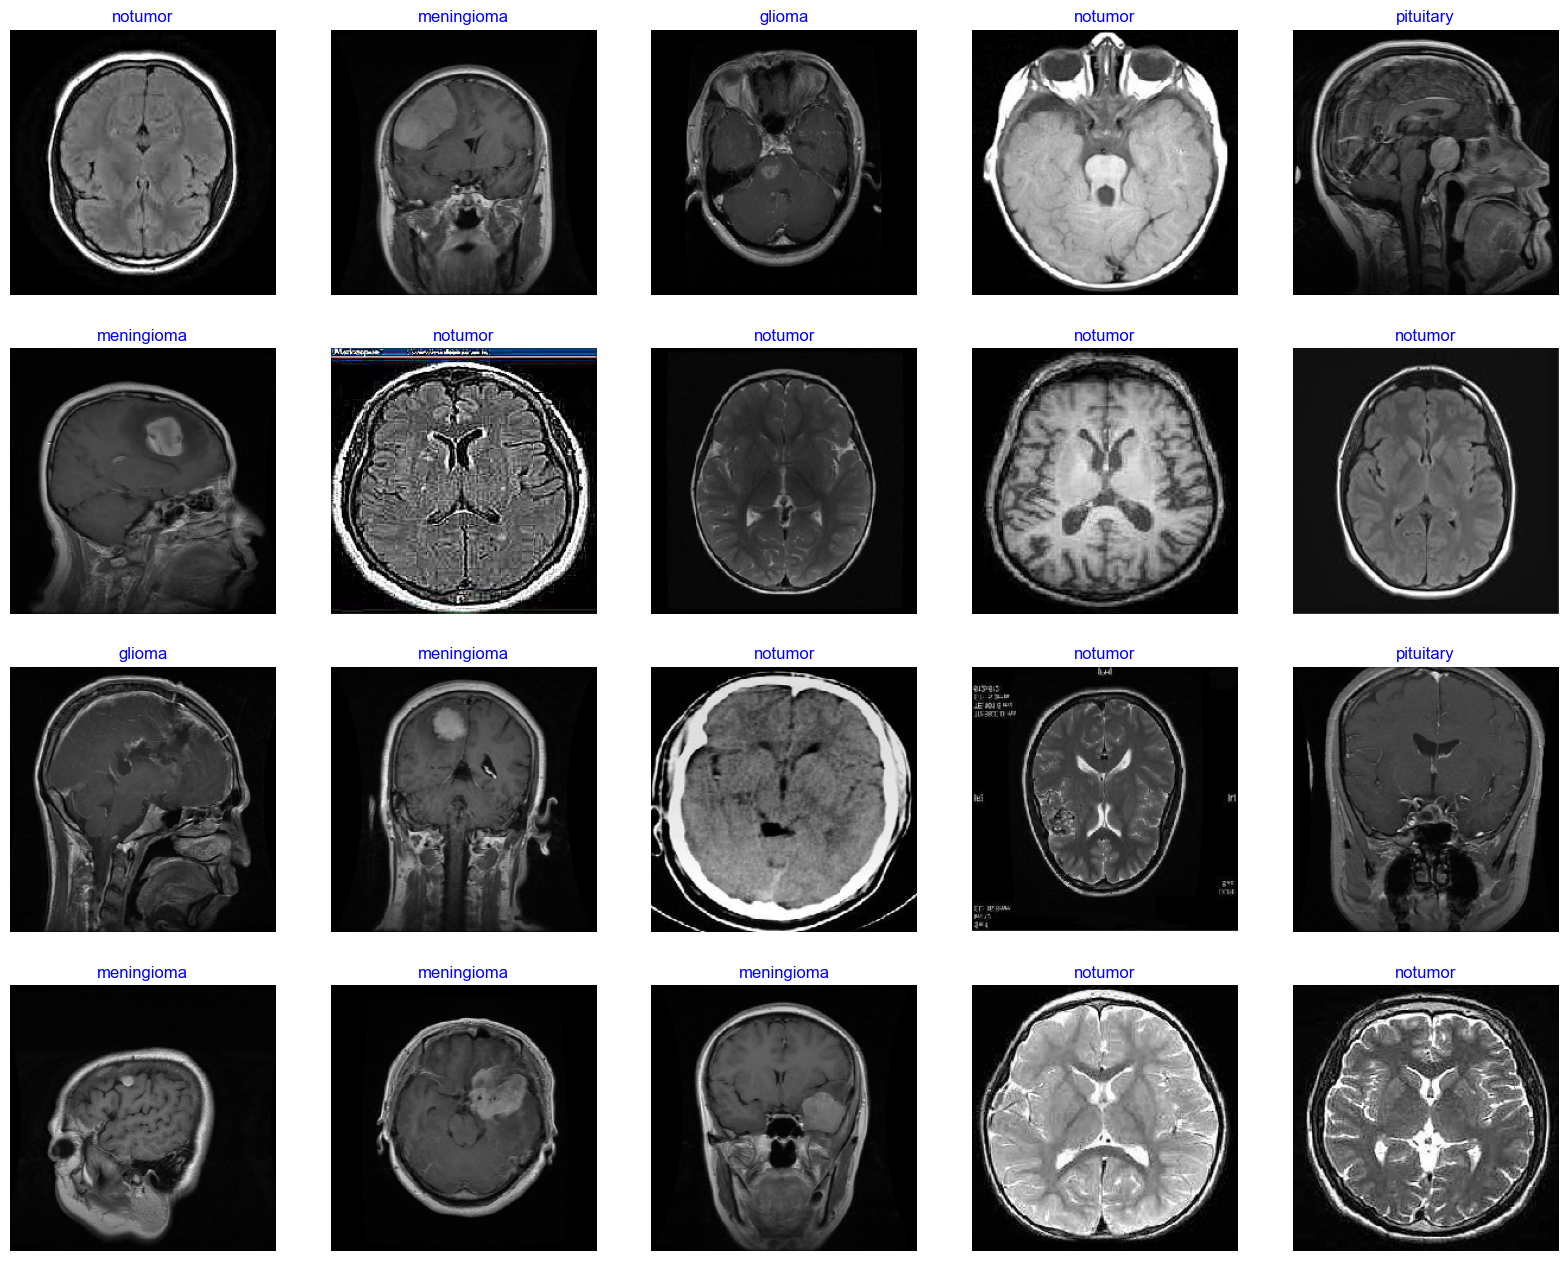

In [8]:
# Get Dataframes
train_dir = 'brain_tumor/Training'
test_dir = 'brain_tumor/Testing'
train_df, valid_df, test_df = split_data(train_dir, test_dir)

# Get Generators
batch_size = 20
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

# Display Image Samples
show_images(train_gen)

In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_______________________________________

In [10]:
batch_size = 20     # set batch size for training
epochs = 20         # number of all epochs in training
patience = 1 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 3		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [11]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /20     6.427   85.927   4.72872  94.838   0.00100  0.00100  accuracy     0.00   2240.22 
 2 /20     3.704   94.682   2.79823  97.988   0.00100  0.00100  val_loss    40.82   1608.82 
 3 /20     2.244   97.199   1.73620  96.588   0.00100  0.00100  val_loss    37.95   2202.12 
enter H to halt training or an integer for number of epochs to run then ask again
2
 training will continue until epoch 5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 4 /20     1.374   98.030   1.03007  98.250   0.00100  0.00100  val_loss    40.67   2937.19 
 5 /20     0.858   98.337   0.64596  98.863   0.00100  0.00100  val_loss    37.29   1264.03 
enter H to halt training or an integer for number of epochs to run then ask again
H
training has been halted at epoch 5 due to user input
training elapsed time was 3.0 hou

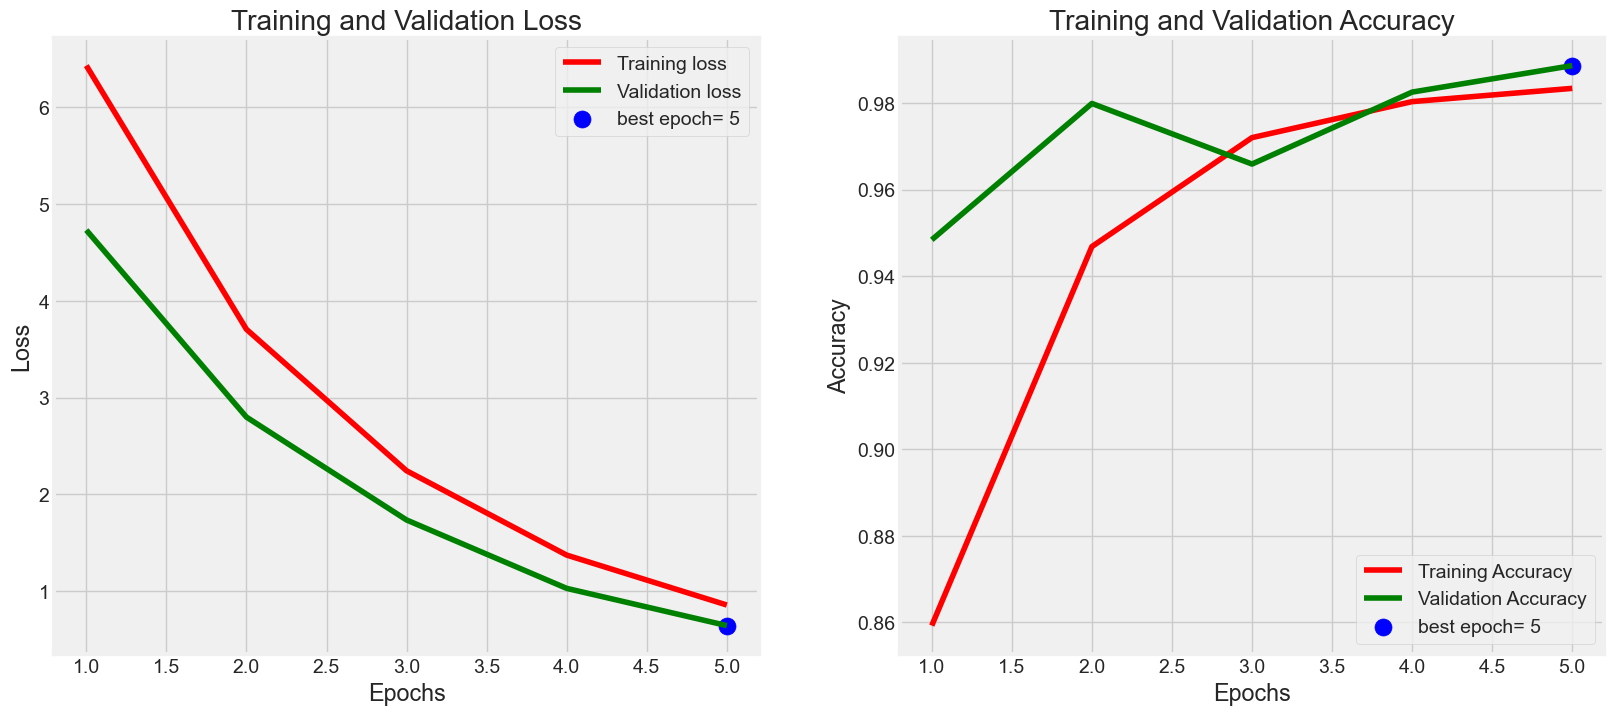

In [12]:
plot_training(history)

In [13]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

19/19 [==============================] - 70s 4s/step - loss: 0.6475 - accuracy: 0.9863
Train Loss:  0.6199331879615784
Train Accuracy:  1.0
--------------------
Validation Loss:  0.6527304649353027
Validation Accuracy:  0.9868420958518982
--------------------
Test Loss:  0.6475360989570618
Test Accuracy:  0.986270010471344


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 0 ... 3 3 3]


Confusion Matrix, Without Normalization
[[288  10   0   2]
 [  0 303   2   1]
 [  0   0 405   0]
 [  1   2   0 297]]
              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       300
  meningioma       0.96      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



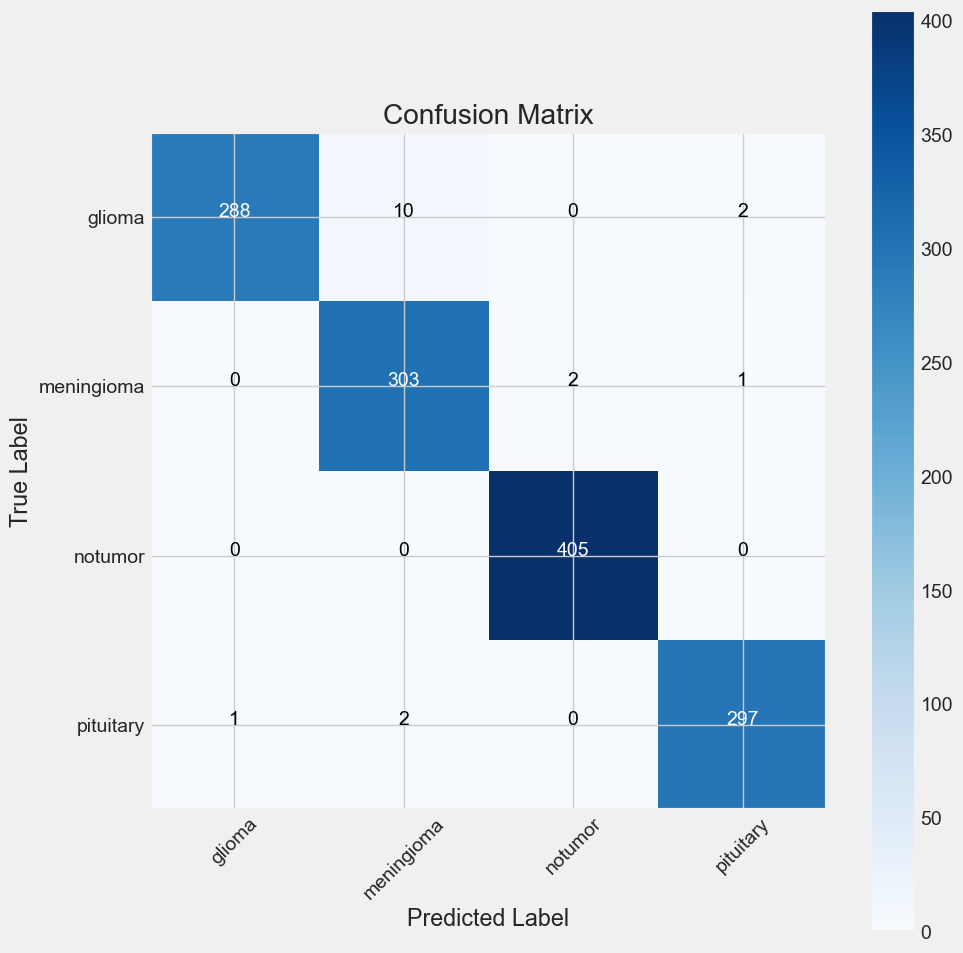

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))